## Testing the irrigated extents MaxNDVI workflow

multithreaded version below 18/4/19

In [ ]:
#regression of irrigation against ENSO

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [209]:
nino34_monthly = pd.read_csv('data/NINO34ANOMS.csv', header=None, usecols=list(range(1,13)))
nino34_monthly = df.transpose()
nino34_monthly = pd.Series(df.values.ravel('F'))
dates = pd.date_range(start='1/1/1987', end='1/01/2020', freq='M')
nino34_monthly = pd.DataFrame({"date":dates, 'nino34_monthly': nino34_monthly}).set_index('date')

In [219]:
nino34_yearly = nino34_monthly.resample('Y').mean()
nino34_yearly = nino34_yearly.drop(pd.DatetimeIndex(['2011-12-31', '2012-12-31']))
nino34_yearly = nino34_yearly.drop(nino34_yearly.index[[0]])

In [190]:
def group_customSeason(df):
    df['month'] = df.index.month
    summer = df['month'].isin([11,12,1,2,3])
    df = df.where(summer)
    df = df.dropna(axis=0, how="all")
    df = df.drop('month', axis=1)
    df = df.drop(df.index[[0,1]])
    df = df.rolling(5).mean()[::5]
    df = df.dropna(axis=0, how="all")
    return df

nino34_summer = group_customSeason(nino34_monthly)

In [196]:
irr_area = pd.read_csv('results/nmdb_plots/csvs/NMDB_annual_area.csv')['irrigated area']
mean_area = irr_area.mean()
irr_anom = irr_area - mean_area

In [220]:
nino34_summer['Irrigated Area (ha)'] = list(irr_area)
nino34_yearly['Irrigated Area (ha)'] = list(irr_area)

In [ ]:
rain = pd.read_csv('data/mdb_rainfall.csv')
rain = rain.drop([0,24,25])

In [292]:
x = np.array(nino34_summer['nino34_monthly']).reshape((-1, 1))
x1 = np.array(nino34_yearly['nino34_monthly']).reshape((-1, 1))
x2= np.array(list(irr_anom)).reshape((-1, 1))
y = np.array(nino34_summer['Irrigated Area (ha)'])
y1 = np.array(rain['rainfall_anomaly'])

In [294]:
model = LinearRegression().fit(x, y)
model1 = LinearRegression().fit(x1, y)
model2 = LinearRegression().fit(x2, y)
model3 = LinearRegression().fit(x2[:-1], y1)

In [236]:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.05730262611814996


In [237]:
r_sq1 = model1.score(x, y)
print('coefficient of determination:', r_sq1)

coefficient of determination: 0.05709694409154664


In [238]:
r_sq2 = model2.score(x, y)
print('coefficient of determination:', r_sq2)

coefficient of determination: -4.995294482501578e-06


In [295]:
r_sq3 = model3.score(x, y)
print('coefficient of determination:', r_sq3)

coefficient of determination: -15.986302701609667


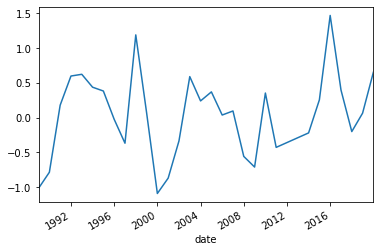

In [243]:
nino34_yearly['nino34_monthly'].plot()

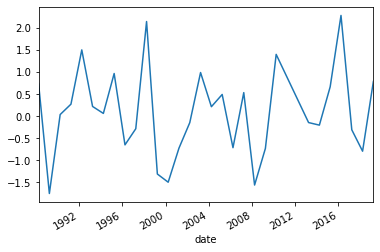

In [244]:
nino34_summer['nino34_monthly'].plot()

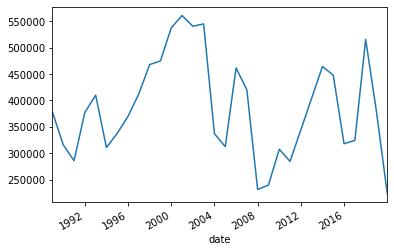

In [241]:
nino34_yearly['Irrigated Area (ha)'].plot()

In [ ]:
# gdal.Translate(meanImage[:-4]+".tif", meanImage, format='GTIFF', outputSRS='EPSG:3577')

In [ ]:
############
#User Inputs
############

# where are the dcStats MaxNDVI tifs?
MaxNDVItiffs = "/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/New folder/maxndvi/"

# where are the dcStats NDVIArgMaxMin tifs?
NDVIArgMaxMintiffs = "/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/New folder/argmaxndvi/"

# where should I put the results?
results = '/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/summer/previous_run/testing_mosaics/results/'

#what season are we processing?
season = 'Summer'

#Input your area of interest's name
AOI = 'rsgislibe_test_tiled'

In [ ]:
def irrigated_extent(tif):
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("starting processing of " + tif)
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    results_ = results
    if season == 'Summer':
        year = tif[9:13]
        nextyear = str(int(year) + 1)[2:] 
        year = year + "_" + nextyear
        year = season + year
        argmaxminyear = "NDVIArgMaxMin_" + year[6:10] + "1101.tif" 
    if season == 'Winter':
        year = tif[7:11]
        year = season + year
        argmaxminyear = "NDVIArgMaxMin_" + year[6:10] + "0501.tif" 

    #Creating a folder to keep things neat
    directory = results_ + AOI + "_" + year
    if not os.path.exists(directory):
        os.mkdir(directory)

    results_ = results_ + AOI + "_" + year + "/"
    
    #inputs to GDAL and RSGISlib
    InputNDVIStats = MaxNDVItiffs + tif
    KEAFile = results_ + AOI + '_' + year + '.kea'
    SegmentedKEAFile = results_ + AOI + '_' + year + '_sheperdSEG.kea'
    meanImage = results_ + AOI + '_' + year + "_ClumpMean.kea"
     
    # Change the tiff to a kea file
    gdal.Translate(KEAFile, InputNDVIStats, format='KEA', outputSRS='EPSG:3577')
    
    # Run segmentation, with creation of clump means
#     segutils.runShepherdSegmentation(KEAFile, SegmentedKEAFile,
#                         meanImage, numClusters=20, minPxls=100)

    tiledsegsingle.performTiledSegmentation(KEAFile, SegmentedKEAFile, tmpDIR='tmps/tiledsegtmp'+year,
                                        tileWidth=1000, tileHeight=1000, minPxls=100)
    
    print('done')
#     segment_means= xr.open_rasterio(meanImage).squeeze()
    
#     #reclassify and threshold by different values
#     a = np.where(segment_means.values>=0.8, 80, segment_means)
#     b = np.where((a>=0.75) & (a<0.8), 75, a)
#     c = np.where((b>=0.70) & (b<0.75), 70, b)
#     d = np.where(c>=70, c, np.nan)
    
#     print('exporting the multithreshold as Gtiff')
#     transform, projection = transform_tuple(segment_means, (segment_means.x, segment_means.y), epsg=3577)
#     #find the width and height of the xarray dataset we want to mask
#     width,height = segment_means.shape
    
#     SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_multithreshold.tif",
#                   d, geo_transform = transform, 
#                   projection = projection, 
#                   nodata_val=np.nan)
    
#     #converting irrigated areas results to polygons
#     print('converting multithreshold tiff to polygons...')
#     multithresholdTIFF = results_ + AOI + "_" + year + "_multithreshold.tif"
#     multithresholdPolygons = results_ + AOI + '_' + year + '_multithreshold.shp'
    
#     os.system('gdal_polygonize.py ' + multithresholdTIFF + ' -f' + ' ' + '"ESRI Shapefile"' + ' ' + multithresholdPolygons)
    
#     #filter by the area of the polygons to get rid of any forests etc
#     print('filtering polygons by size, exporting, then rasterizing')
#     gdf = gpd.read_file(multithresholdPolygons)
#     gdf['area'] = gdf['geometry'].area
#     smallArea = gdf['area'] <= 10000000
#     gdf = gdf[smallArea]
#     #export shapefile
#     gdf.to_file(results_ + AOI + "_" + year + "_Irrigated.shp")
    
#     gdf_raster = SpatialTools.rasterize_vector(results_ + AOI + "_" + year + "_Irrigated.shp",
#                                                height, width, transform, projection, raster_path=None)
    
#     print('loading, then masking timeof rasters')
#     argmaxmin = xr.open_rasterio(NDVIArgMaxMintiffs+argmaxminyear)
#     timeofmax = argmaxmin[0] 
#     timeofmin = argmaxmin[1]

#     # mask timeof layers by irrigated extent
#     timeofmax = timeofmax.where(gdf_raster)
#     timeofmin = timeofmin.where(gdf_raster)

#     # export masked timeof layers.
#     print('exporting the timeofmaxmin Gtiffs')
#     SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_timeofmaxNDVI.tif",
#                   timeofmax.values,
#                   geo_transform = transform, 
#                   projection = projection, 
#                   nodata_val=-9999)

#     SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_timeofminNDVI.tif",
#                   timeofmin.values,
#                   geo_transform = transform, 
#                   projection = projection, 
#                   nodata_val=-9999)
    

In [ ]:
maxNDVItiffFiles = os.listdir(MaxNDVItiffs)

if __name__ == '__main__':
    pool = Pool(os.cpu_count()-5)  #use 3 cpus on vdi
    pool.map(irrigated_extent, maxNDVItiffFiles)

In [ ]:
maxNDVItiffFiles = os.listdir(MaxNDVItiffs)

irrigated_extent(maxNDVItiffFiles[0])



In [ ]:
data = xr.open_rasterio('path/to/data').squeeze()
area = np.count_nonzero(~np.isnan(data.values))*(25*25) / 10000
area

In [ ]:
#generate list of inputs for GNU parallel
import os
maxNDVItiffFiles = os.listdir("/g/data/r78/cb3058/dea-notebooks/dcStats/results/renmark")
maxNDVItiffFiles.sort()
with open('renmark_maxNDVItiffFiles.txt', 'w') as f:
    for item in maxNDVItiffFiles:
        f.write("%s\n" % item)

In [ ]:
tiff = "/g/data1a/r78/cb3058/dea-notebooks/ICE_project/results/renmark/renmark_Summer2016_17/renmark_Summer2016_17_multithreshold_irrigated.tif"

In [ ]:
NDVI_max_Irrigated = xr.open_rasterio(tiff).squeeze()
# NDVI_max_Irrigated.plot(figsize=(20,16))

In [ ]:
width,height = NDVI_max_Irrigated.shape
transform, projection = transform_tuple(NDVI_max_Irrigated, (NDVI_max_Irrigated.x, NDVI_max_Irrigated.y), epsg=3577)

In [ ]:
#remove pixels that cross over the major rivers in the region
rivers_raster = SpatialTools.rasterize_vector("data/spatial/major_rivers_aus.shp", height, width, transform, projection, raster_path=None)
rivers_raster = rivers_raster.astype(bool)
from scipy.ndimage.morphology import binary_dilation as bd
rivers_raster = bd(rivers_raster)

rivers_raster = xr.DataArray(rivers_raster, coords = [NDVI_max_Irrigated.y, NDVI_max_Irrigated.x], dims = ['y', 'x'], name='rivers')
masked_irr = NDVI_max_Irrigated.where(rivers_raster == 0)

In [ ]:
# masked_irr.plot(figsize=(20,16))

In [ ]:
ones = np.count_nonzero((~np.isnan(masked_irr.values)))
area = (ones*(25*25)) / 1000000
print(str(area) + " km2 was under irrigated cultivation")

In [ ]:
ones = np.count_nonzero((~np.isnan(NDVI_max_Irrigated.values)))
area = (ones*(25*25)) / 1000000
print(str(area) + " km2 was under irrigated cultivation")

In [ ]:
transform, projection = transform_tuple(a, (a.x, a.y), epsg=3577)
#find the width and height of the xarray dataset we want to mask
width,height = a.shape

SpatialTools.array_to_geotiff("/g/data/r78/cb3058/dea-notebooks/ICE_project/results/renmark/renmark_Summer2015_16/renmark_Summer2015_16_ClumpMean.tif",
              a.values, geo_transform = transform, 
              projection = projection, 
              nodata_val=np.nan)

In [ ]:
a

In [ ]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from osgeo import gdal, ogr
import os
from multiprocessing import Pool, cpu_count
from rsgislib.segmentation import segutils

import datacube 
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.utils import geometry

#import custom functions
import sys
sys.path.append('src')
import DEAPlotting, SpatialTools
from transform_tuple import transform_tuple

############
#User Inputs
############

#how many cpus should the job be distrubuted over?
# cpus = 8

# where are the dcStats MaxNDVI tifs?
MaxNDVItiffs = "/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/summer/ndvi_max/mosaics/"

# where are the dcStats NDVIArgMaxMin tifs?
NDVIArgMaxMintiffs = "/g/data/r78/cb3058/dea-notebooks/dcStats/results/mdb_NSW/summer/ndviArgMaxMin/mosaics"

#Is there an irrigatable area shapefile we're using for masking?
# irrigatable_area = False
# irrigatable_area_shp_fpath = "/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/NSW_OEH_irrigated_2013.shp"

#Shapefile we're using for clipping the extent? e.g. just the northern basins
northernBasins_shp = "/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/northern_basins.shp"

# where should I put the results?
results = '/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/'

#what season are we processing (Must be 'Summmer' or 'Winter')?
season = 'Summer'

#Input your area of interest's name
AOI = 'nmdb'

# script proper-----------------------------

def irrigated_extent(tif):
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("starting processing of " + tif)
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    results_ = results
    
    if season == 'Summer':
        year = tif[9:13]
        nextyear = str(int(year) + 1)[2:] 
        year = year + "_" + nextyear
        year = season + year
        argmaxminyear = "ndviArgMaxMin_" + year[6:10] + "1101_mosaic.tif" 
    if season == 'Winter':
        year = tif[7:11]
        year = season + year
        argmaxminyear = "ndviArgMaxMin_" + year[6:10] + "0501_mosaic.tif" 

    #Creating a folder to keep things neat
    directory = results_ + AOI + "_" + year
    if not os.path.exists(directory):
        os.mkdir(directory)

    results_ = results_ + AOI + "_" + year + "/"
    
    #limiting the extent to the northern basins
    print('clipping extent to provided polygon')
    NDVI_max = xr.open_rasterio(MaxNDVItiffs + tif).squeeze()

    transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
    width,height = NDVI_max.shape

    clip_raster = SpatialTools.rasterize_vector(northernBasins_shp, height, width,
                                                transform, projection, raster_path=None)

    NDVI_max = NDVI_max.where(clip_raster)
    print("exporting clippedndvi_max geotiff")
    SpatialTools.array_to_geotiff(results_ + AOI + "_" + year + "_NDVI_max.tif",
          NDVI_max.values,
          geo_transform = transform, 
          projection = projection, 
          nodata_val = 0)

In [ ]:
cpus=1
maxNDVItiffFiles = os.listdir(MaxNDVItiffs)    
pool = Pool(cpus)  
pool.map(irrigated_extent, maxNDVItiffFiles)


### Testing for threaded image seg

Pete's bit bucket for the function is here:

https://bitbucket.org/petebunting/rsgislib/src/default/python/rsgislib/segmentation/tiledsegsingle.py

In [ ]:
def threadedTiledImgSeg(imgTile):
    baseName = os.path.splitext(os.path.basename(imgTile))[0]
    tileID = baseName.split('_')[-1]
    clumpsFile = os.path.join(stage1TilesSegsDIR, baseName + '_segs.kea')
    tmpStatsJSON = os.path.join(tilesImgDIR, baseName + '_segstats.json')
    strchStatsOutFile = strchStatsBase + "_" + tileID + '.txt'
    kCentresOutFile = kCentresBase + "_" + tileID
    print(clumpsFile)
    segutils.runShepherdSegmentation(imgTile, clumpsFile, outputMeanImg=None, tmpath=os.path.join(tmpDIR,tileID+'_segstemp'), gdalformat='KEA', noStats=False, noStretch=False, noDelete=False, numClusters=numClustersVal, minPxls=minPxlsVal, distThres=distThresVal, bands=bandsVal, sampling=samplingVal, kmMaxIter=kmMaxIterVal, processInMem=False, saveProcessStats=True, imgStretchStats=strchStatsOutFile, kMeansCentres=kCentresOutFile, imgStatsJSONFile=tmpStatsJSON)

    with open(tmpStatsJSON, 'r') as f:
        jsonStrData = f.read()
    segStatsInfo = json.loads(jsonStrData)
    tileStatsFiles[baseName] = segStatsInfo
    os.remove(tmpStatsJSON)

pool = Pool(7)
pool.map(threadedTiledImgSeg, imgTiles)
